# main.ipynb

In [44]:
# Import General packages
import os
import sys
from pathlib import Path
from tqdm import tqdm

# Import Calculation packages
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.colors import CenteredNorm

# Import Images and OpenPIV methods
import imageio.v2 as imageio
from PIL import Image
from openpiv import tools, pyprocess, validation, filters, scaling

In [4]:
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), 'src')))
from utils import *
from PIVAnalysis import *

In [46]:
# Get datasets directory
folder_path = Path.cwd() / 'data' / 'background_subtracted_trial' 
file_list = os.listdir(folder_path)

# Read image
i = 0
image_path = folder_path / file_list[i]
movie = imageio.imread(image_path)

print(f'{file_list[i]} loaded successfully')

edited_background_subtracted_20241126_3_PYO5_4x_R1_beads_75um_up-1.tif loaded successfully


## Parameters for PIV

In [33]:
# -- Pre-processing
WINDSIZE:int = 32 # pixels, interrogation window size in frame 't'
SEARCHSIZE:int = 38  # pixels, search area size in frame 't+1'
OVERLAP:int = 17 # pixels, 50% overlap
DT:float = 0.25 # sec, time interval between the two frames
#PX2UM:float = 2.75 # pixels/micrometers
PX2UM:float = 1 # pixels/micrometers
# -- Post-processing
S2N_THRESHOLD:float = 1.05 # AU, signal-to-noise threshold to remove false values

In [ ]:
# Test movie
# a subset of 300x300 pixels on the top left corner of the original image

test_movie = movie[:, :300, :300]

(120, 300, 300)


check if piv_image2image is working
- display t & t+1
- display resulting vectors

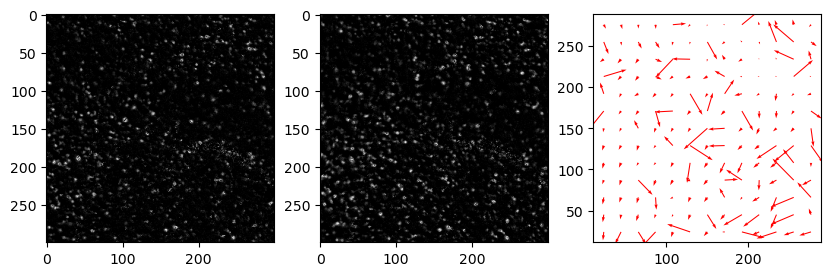

In [ ]:
frame_a = adjust_contrast(test_movie[0,:,:])
frame_b = adjust_contrast(test_movie[1,:,:])

x, y, u, v = piv_image2image(
    frame_a, 
    frame_b, 
    WINDSIZE, 
    SEARCHSIZE, 
    OVERLAP, 
    DT, 
    PX2UM, 
    S2N_THRESHOLD)

# Plot
fig, ax = plt.subplots(1, 3, figsize=(10, 10))
ax[0].imshow(frame_a, cmap='gray')
ax[1].imshow(frame_b, cmap='gray')
ax[2].quiver(x, y, u, v, color='r')
ax[2].set_aspect('equal')

plt.show()

### Effect of parameters

effect of window size on the same image subset
- 16 px
- 32 px
- 64 px
CONSTANT PARAMETERS = overlap stays at 50%

0
1
2


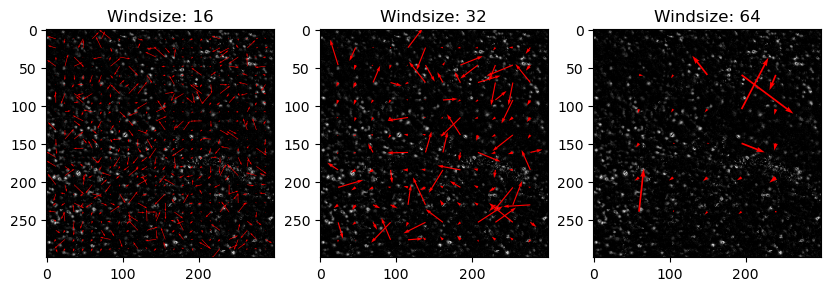

In [ ]:
test_windsize = [16, 32, 64]
frame_a = adjust_contrast(test_movie[0,:,:])
frame_b = adjust_contrast(test_movie[1,:,:])

fig, ax = plt.subplots(1, len(test_windsize), figsize=(10, 10))
for index, value in enumerate(test_windsize):
    x, y, u, v = piv_image2image(
        frame_a, 
        frame_b, 
        value, 
        math.ceil(value * 1.2), 
        math.ceil(value / 2), 
        DT, 
        PX2UM, 
        S2N_THRESHOLD)

    # Plot
    ax[index].imshow(frame_a, cmap='gray')
    ax[index].quiver(x, y, u, v, color='r')
    ax[index].set_title(f'Windsize: {value}')

plt.show()

effect of frame skipping on the same image subset
- 1:1
- 1:2
- 1:4
- 1:8
CONSTANT PARAMETERS = S2N at 1.05

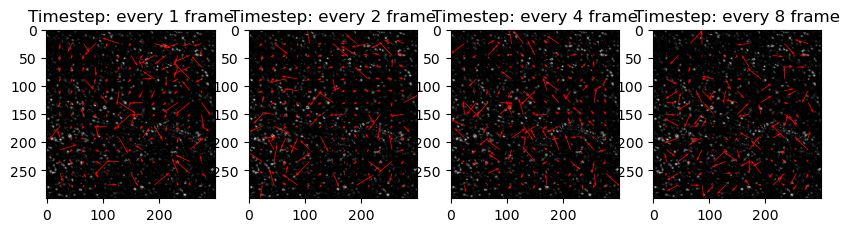

In [34]:
test_dt = [1, 2, 4, 8]
frame_a = adjust_contrast(test_movie[0,:,:])

fig, ax = plt.subplots(1, len(test_dt), figsize=(10, 10))
for index, value in enumerate(test_dt):
    frame_b = adjust_contrast(test_movie[0+value,:,:])

    x, y, u, v = piv_image2image(
        frame_a, 
        frame_b, 
        WINDSIZE, 
        SEARCHSIZE, 
        OVERLAP, 
        DT*value, 
        PX2UM, 
        S2N_THRESHOLD)

    # Plot
    ax[index].imshow(frame_a, cmap='gray')
    ax[index].quiver(x, y, u, v, color='r')
    ax[index].set_title(f'Timestep: every {value} frame')

plt.show()

effect of S2N
- 1.05
- 1.025
- 1.1
- 1.3

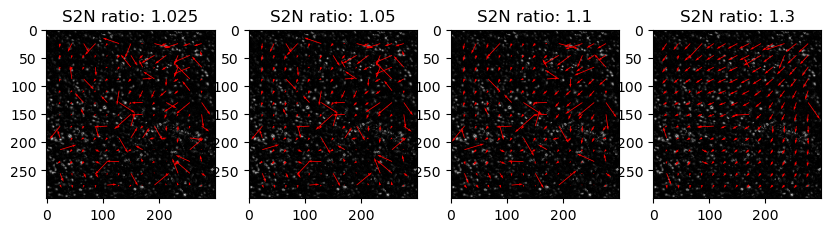

In [35]:
test_s2n = [1.025, 1.05, 1.1, 1.3]
frame_a = adjust_contrast(test_movie[0,:,:])
frame_b = adjust_contrast(test_movie[1,:,:])

fig, ax = plt.subplots(1, len(test_s2n), figsize=(10, 10))
for index, value in enumerate(test_s2n):
    x, y, u, v = piv_image2image(
        frame_a, 
        frame_b, 
        WINDSIZE, 
        SEARCHSIZE, 
        OVERLAP, 
        DT, 
        PX2UM, 
        value)

    # Plot
    ax[index].imshow(frame_a, cmap='gray')
    ax[index].quiver(x, y, u, v, color='r')
    ax[index].set_title(f'S2N ratio: {value}')

plt.show()

combined effect of S2N + timestep

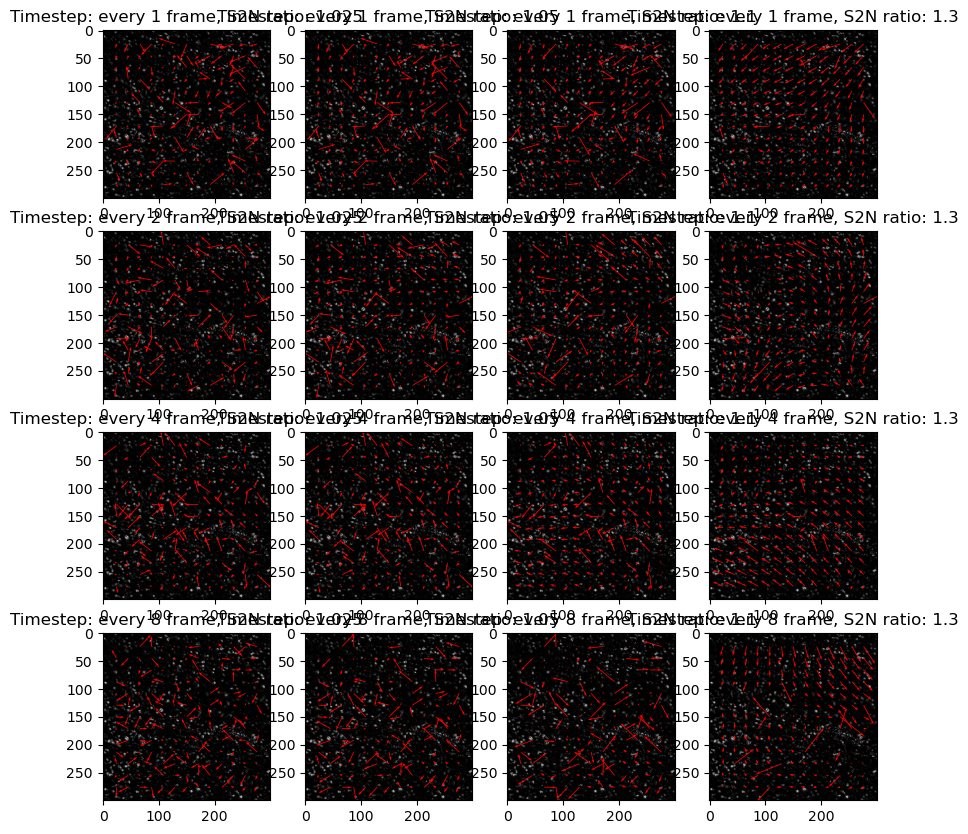

In [40]:
test_dt = [1, 2, 4, 8]
test_s2n = [1.025, 1.05, 1.1, 1.3]
frame_a = adjust_contrast(test_movie[0,:,:])

fig, ax = plt.subplots(len(test_dt), len(test_s2n), figsize=(10, 10))
for index_dt, value_dt in enumerate(test_dt):
    for index_s2n, value_s2n in enumerate(test_s2n):
        frame_b = adjust_contrast(test_movie[0+value_dt,:,:])

        x, y, u, v = piv_image2image(
            frame_a, 
            frame_b, 
            WINDSIZE, 
            SEARCHSIZE, 
            OVERLAP, 
            DT*value_dt, 
            PX2UM, 
            value_s2n)

        # Plot
        ax[index_dt, index_s2n].imshow(frame_a, cmap='gray')
        ax[index_dt, index_s2n].quiver(x, y, u, v, color='r')
        ax[index_dt, index_s2n].set_title(f'Timestep: every {value_dt} frame, S2N ratio: {value_s2n}')

plt.show()

## Mean values

In [ ]:
# Compute entire movie
x, y, u, v = piv_movie(
                test_movie,
                WINDSIZE, 
                SEARCHSIZE, 
                OVERLAP, 
                DT, 
                PX2UM, 
                S2N_THRESHOLD)

100%|██████████| 119/119 [00:12<00:00,  9.45it/s]


compute over the film
- norm
- divergence
- vorticity

  0%|          | 0/118 [00:00<?, ?it/s]

100%|██████████| 118/118 [00:00<00:00, 1733.28it/s]


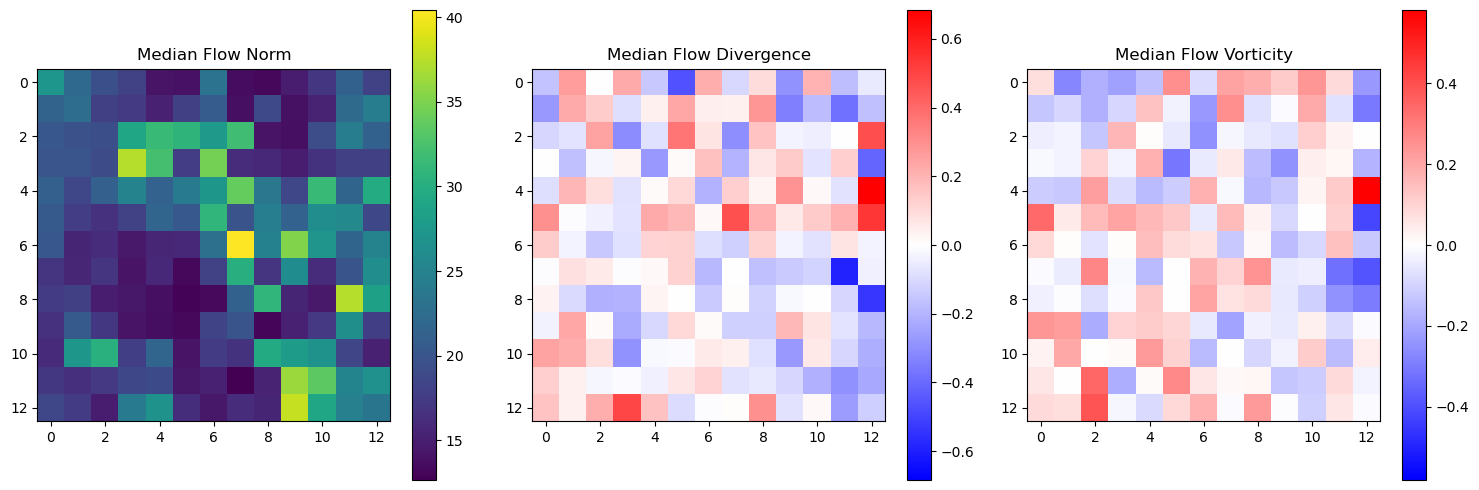

In [45]:
flow_norm, flow_divergence, flow_vorticity = movie_flow_features(x, y, u, v, start=0, end=u.shape[0])

# Median values on 2D map over the course of the film
fig, ax = plt.subplots(1, 3, figsize=(15,5))

# Norm
mean_flow_norm = np.median(flow_norm, axis=0)
im0 = ax[0].imshow(mean_flow_norm, cmap='viridis')
ax[0].set_title('Median Flow Norm')
plt.colorbar(im0, ax=ax[0])

# Divergence
mean_flow_divergence = np.median(flow_divergence, axis=0)
im1 = ax[1].imshow(mean_flow_divergence, cmap='bwr', norm=CenteredNorm())
ax[1].set_title('Median Flow Divergence')
plt.colorbar(im1, ax=ax[1])

# Vorticity
mean_flow_vorticity = np.median(flow_vorticity, axis=0)
im2 = ax[2].imshow(mean_flow_vorticity, cmap='bwr', norm=CenteredNorm())
ax[2].set_title('Median Flow Vorticity')
plt.colorbar(im2, ax=ax[2])

plt.tight_layout()
plt.show()